In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from PIL import Image

from utils.coords import *
from utils.noise import *
from utils.metrics import *
from analysis.peaksdata import *

%matplotlib inline
mpl.rcParams['image.cmap'] = 'terrain'

In [4]:
np.random.seed(42)

# Constants

In [5]:
promEpsilon   = 30   # m,  minimum prominence threshold in the analysis
diskRadius    = 30   # km, used for the analysis to normalize histograms 
globalMaxElev = 9000 # m,  any value larger than any other peak elevation, used internally as initialization and undefineds

terrainUnitKm  = 90  # km, size of terrain
km2pixels = 1000/30  # 30 m/pixel

# process each region (note: it takes a long time!)
regionShapesDir = 'data/regionShapes'
regionPeaksDir = 'data/regionPeaks'
regionSeqsDir = 'data/regionSeqs'
regionTreeSeqsDir = 'data/regionTreeSeqs'


regionShapes = ['andes_peru.shp']

# Compute Distributions

filterCoords: filter centor position

In [6]:
#regionName, filterCoords = 'pyrenees', [42.5893, 0.9377] # pyrenees: aiguestortes
#regionName, filterCoords = 'alps', [45.8325,  7.0]  # mont blanc
#regionName, filterCoords = 'alps', [44.8742,  6.5]  # ecrins
#regionName, filterCoords = 'alps', [46.4702, 11.9492] # dolomites
#regionName, filterCoords = 'alps', [46.0159, 7.74318] # valais
#regionName, filterCoords = 'sahara', [30.38, 8.69] # sahara dunes
#regionName, filterCoords = 'andes_chile', [-21.4483, -68.0708] # chile
#regionName, filterCoords = 'karakoram', [35.8283, 76.3608] # karakoram
#regionName, filterCoords = 'colorado', [39.0782,-106.6986] # colorado
#regionName, filterCoords = 'yangshuo', [24.9917, 110.4617] # yangshuo
#regionName, filterCoords = 'himalaya', [28.7150, 84.2000] # himalaya: annapurna
#regionName, filterCoords = 'himalaya', [27.8575, 86.8267] # himalaya: everest
#regionName, filterCoords = 'norway', [62.1167, 6.8075] # norway
#regionName, filterCoords = 'alaska', [62.9500, -151.0908] # alaska
#regionName, filterCoords = 'patagonia', [-50.8925, -73.1533] # patagonia
#regionName, filterCoords = 'andes_aconcagua', [-32.6533, -70.0108] # aconcagua
regionName, filterCoords = 'andes_peru', [-9.0874, -77.5737] # huascaran
#regionName, filterCoords = 'rockies', [50.8003, -116.29517] # canadian rockies
#regionName, filterCoords = 'appalachians', [35.3855, -83.2380] # appalachians
#regionName, filterCoords = 'highlands', [56.9667, -3.5917] # highlands

peaksFile = 'data/regionPeaks/%s.csv' % regionName

filterRadius = 45 # km
filterHWidth = [km2deg(filterRadius), km2deg(filterRadius, filterCoords[0])]
print("filter scope: ",filterCoords[0] - filterHWidth[0], filterCoords[0] + filterHWidth[0],
      filterCoords[1] - filterHWidth[1], filterCoords[1] + filterHWidth[1])

# read peaks file and filter region of interest
df = pd.read_csv(peaksFile)

filat = np.logical_and(df['latitude']  > filterCoords[0] - filterHWidth[0], 
                       df['latitude'] < filterCoords[0] + filterHWidth[0])
filon = np.logical_and(df['longitude'] > filterCoords[1] - filterHWidth[1], 
                       df['longitude'] < filterCoords[1] + filterHWidth[1])
df = df[np.logical_and(filat, filon)]

print('Peaks:', df.shape[0])

# compute distributions
df = addExtraColumns(df)
distributions = computeDistributions(df, diskRadius)

filter scope:  -9.49232387431163 -8.682476125688371 -77.98377085251597 -77.16362914748403
Peaks: 1057


### Visualize the peaks

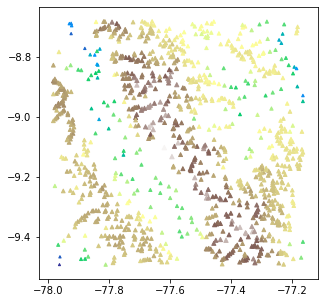

In [7]:
fig = plt.figure(figsize=(5,5))
_ = plt.scatter(df['longitude'], df['latitude'], marker='^', 
                s=20*df['elev'].values/df['elev'].values.max(), c=df['elev'].values/df['elev'].values.max())

### Visualize distributions

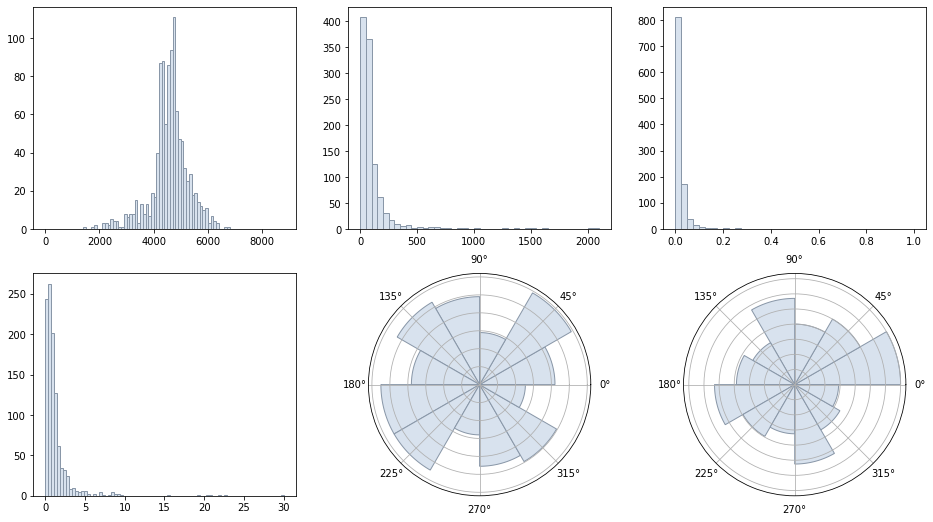

In [8]:

barColor  = (216/255, 226/255, 238/255, 1.0)
edgeColor = (137/255, 151/255, 168/255, 1.0)

fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(231)
h = ax.bar(distributions['elevation']['x'],
           distributions['elevation']['hist'], 
           width=np.diff(distributions['elevation']['bins']), color=barColor, edgecolor=edgeColor)

ax = fig.add_subplot(232)
h = ax.bar(distributions['prominence']['x'],
           distributions['prominence']['hist'], 
           width=np.diff(distributions['prominence']['bins']), color=barColor, edgecolor=edgeColor)

ax = fig.add_subplot(233)
h = ax.bar(distributions['dominance']['x'],
           distributions['dominance']['hist'], 
           width=np.diff(distributions['dominance']['bins']), color=barColor, edgecolor=edgeColor)

ax = fig.add_subplot(234)
h = ax.bar(distributions['isolation']['x'],
           distributions['isolation']['hist'], 
           width=np.diff(distributions['isolation']['bins']), color=barColor, edgecolor=edgeColor)

ax = fig.add_subplot(235, polar=True)
ax.set_yticklabels([])
h = ax.bar(np.radians(distributions['isolDir']['x']),
           distributions['isolDir']['hist'], 
           width=np.diff(np.radians(distributions['isolDir']['bins'])), color=barColor, edgecolor=edgeColor)

ax = fig.add_subplot(236, polar=True)
ax.set_yticklabels([])
h = ax.bar(np.radians(distributions['saddleDir']['x']),
           distributions['saddleDir']['hist'], 
           width=np.diff(np.radians(distributions['saddleDir']['bins'])), color=barColor, edgecolor=edgeColor)

# Evaluation

In [9]:
def printHistogramsDistances(hbins, hReal, hSynth):
    hdiff = np.abs(hReal - hSynth)
    print('Max', np.max(hdiff), 'Sum', np.sum(hdiff), 'Avg', np.mean(hdiff))
    print('EMD', np.diff(hbins)[0]*np.abs(np.cumsum(hReal) - np.cumsum(hSynth)).sum())
    
def histogramsComparison(distribution, synthesisValues):
    hbins  = distribution['bins']
    hmids  = distribution['x']
    hReal  = distribution['hist']
    hSynth = histogramFromBins(synthesisValues, hbins, frequencies=False)
    hNorm  = np.round(synthesisValues.size * hReal/hReal.sum())

    fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(131)
    _ = ax.bar (hmids, hSynth, width=np.diff(hbins), color=barColor, edgecolor=edgeColor)
    _ = ax.plot(hmids, hNorm, color='r')

    ax = fig.add_subplot(132)
    _ = ax.bar (hmids, hNorm, width=np.diff(hbins), color='g')
    _ = ax.plot(hmids, hNorm, color='r')
    
    printHistogramsDistances(hbins, hReal/hReal.sum(), hSynth/hSynth.sum())
    print('Per bin differences (synthesis - target)')
    print(hSynth - hNorm)

## RNN

### Load generated data

In [10]:
from RNN.generate import *
import torch
import sys
sys.path.insert(0, './RNN')


In [11]:
ptFilename = './RNN/andes_perulittle.pt'
predict_len = 100
decoder = torch.load(ptFilename)
vsequence, predicted = generate(decoder, predict_len, cuda=True, filename='./data/regionTreeSeqs/andes_perulittle.txt')
pointlist = [[df.mean()['longitude'], df.mean()['latitude'], df.mean()['elevation in feet'],df.mean()['prominence in feet']]]
for i in predicted:
    pointlist.append([pointlist[-1][0] + i[1], pointlist[-1][1] + i[2], pointlist[-1][2] + i[3], pointlist[-1][3] + i[4]])
 

initial vseq is: ['[', 'Node', '[', 'Node', '[', 'Node', '[', 'Node']
/home/e/e0509826/DivideTree/RNN/model.py:30: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
[1, -0.0034373630502315252, -0.002610676770559266, 292.65165519755203, 469.643664487798]


In [17]:
print(vsequence)

['[', 'Node', '[', 'Node', '[', 'Node', '[', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', '[', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node']


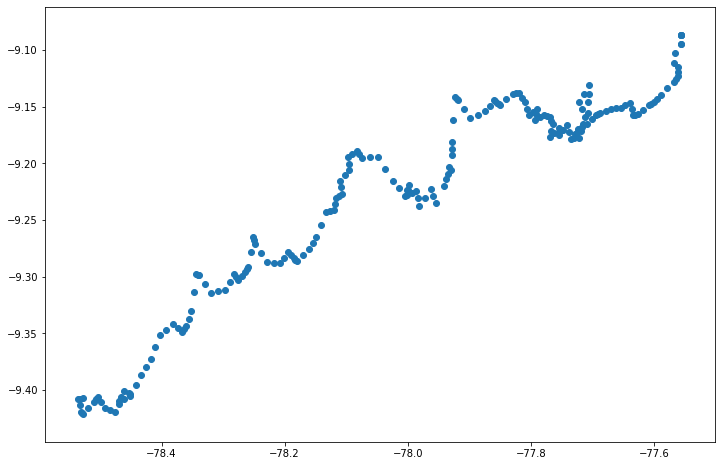

In [18]:
apointlist = np.array(pointlist)
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.scatter(apointlist[:,0], apointlist[:,1])

In [13]:
print(pointlist[1])

[-77.55537294228945, -9.086347303689681, 15034.636707663198, 343.7388836329234]


In [14]:

peakElevs = [feet2m(pointlist[i][2]) for i in range(predict_len+1)]
peakProms = [feet2m(pointlist[i][3]) for i in range(predict_len+1)]

### Elevation Difference

Max 0.10501419110690634 Sum 1.2013263767247113 Avg 0.014301504484817993
EMD 862.9148439914943
Per bin differences (synthesis - target)
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  -1.  -1.   0.   0.   4.   3.   0.   2.   3.   5.   0.   0.  -3.
  -6.  -6.  -3.  -4.  -7. -11.  -3.  -1.  -3.  -2.  -1.  -2.  -1.  -1.
  -1.   2.   3.   1.   5.   2.   1.   2.   2.   3.   3.   5.   3.   3.
   1.   2.   0.   0.   3.   2.   1.   0.   0.   0.   0.   0.   0.   0.]


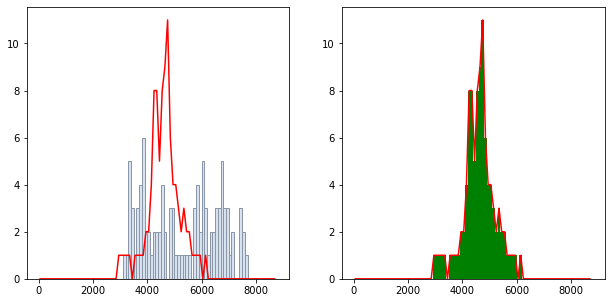

In [15]:
# peakELevs: list of peaks' elevation, in feet
histogramsComparison(distributions['elevation'], np.array(peakElevs))

### Prominece Difference

Max 0.8817407757805109 Sum 1.7634815515610216 Avg 0.043011745160024914
EMD 87.84295175023699
Per bin differences (synthesis - target)
[-39. -35.  -8.  -6.  -3.  -2.  -1.  -1.  -1.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


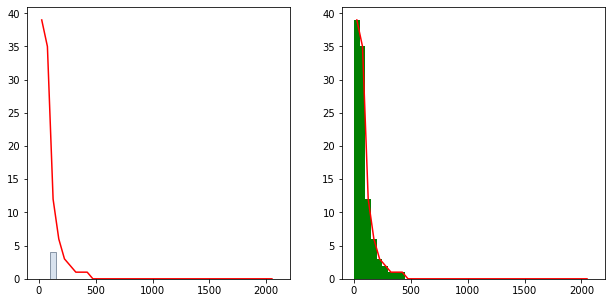

In [16]:
# peakProms: list of peaks' elevation, in feet
histogramsComparison(distributions['prominence'], np.array(peakProms))